
## Exploration (EDA) für `spotify.sqlite`

**Ziel:** Diese Notebook führt eine EDA für den bereitgestellten Spotify-Basisdatensatz (SQLite) durch.

In [7]:

# --- Grundlegendes Setup ---
import sqlite3
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Matplotlib: keine Styles/keine festen Farben setzen
plt.rcParams.update({'figure.figsize': (8, 5), 'axes.grid': True})

RAW_SPOTIFY_DB_PATH = Path("../data/raw/spotify.sqlite")
SCHEMA_REPORTS_DIR = Path("../data/reports/01_schema_overview")
SCHEMA_REPORTS_DIR.mkdir(parents=True, exist_ok=True)


### 1.1 Datenbankstruktur und Tabellenübersicht

Bevor ich mit der eigentlichen Analyse beginne, will ich ein klares Verständnis der Struktur des Spotify-Datenbestands gewinnen.
Dazu prüfe ich:
- Welche Tabellen existieren in der SQLite-Datenbank
- Wie viele Zeilen jede Tabelle enthält
- Welche Spalten und Datentypen sie besitzen
- Welche Felder Primärschlüssel sind


In [39]:
# Verbindung nur für Schema-Abfrage (UTF-8/Bytes egal, da keine Daten gelesen werden)
pd.set_option('display.max_colwidth', None)

con_overview = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))

# Gibt alle Benutzertabellen (ohne SQLite-Systemtabellen) zurück
def list_user_tables(con):
    q = """
    SELECT name
    FROM sqlite_master
    WHERE type='table' AND name NOT LIKE 'sqlite_%'
    ORDER BY name;
    """
    return pd.read_sql(q, con)['name'].tolist()

# Liest Spalteninformationen einer Tabelle (Name, Typ, Primärschlüssel usw.)
def get_table_info(con, table):
    info = pd.read_sql(f"PRAGMA table_info({table});", con)
    return info

# Gibt die Anzahl der Zeilen einer Tabelle zurück
def get_rowcount(con, table):
    try:
        return pd.read_sql(f"SELECT COUNT(*) AS n FROM {table};", con).iloc[0, 0]
    except Exception:
        return None

# Baut eine Gesamtübersicht: Tabellenname, Zeilenanzahl, Spaltenanzahl, Spaltenliste
def build_db_summary(con, max_preview_chars: int = 140):
    tables = list_user_tables(con)
    rows = []
    column_details = {}

    for t in tables:
        info = get_table_info(con, t)
        column_details[t] = info

        # Spaltenliste mit Typ und PK-Markierung
        col_display = [
            f"{r['name']} ({r['type']})" + (" [PK]" if r['pk'] == 1 else "")
            for _, r in info.iterrows()
        ]
        rowcount = get_rowcount(con, t)

        rows.append({
            "table": t,
            "rowcount": rowcount,
            "n_columns": len(col_display),
            "columns_full": ", ".join(col_display)
        })

    summary = pd.DataFrame(rows).sort_values("rowcount", ascending=False)
    # Kürze Spaltenliste für Übersicht (volle Liste bleibt in columns_full)
    summary["columns_preview"] = summary["columns_full"].apply(
        lambda s: s if len(s) <= max_preview_chars else s[:max_preview_chars] + "…"
    )
    summary = summary[["table", "rowcount", "n_columns", "columns_preview", "columns_full"]]
    return summary, column_details

#  Erstelle die Übersicht und zeige sie an
db_summary, db_column_details = build_db_summary(con_overview)

print("Tabellen-Übersicht:")
display(db_summary[["table", "rowcount", "n_columns", "columns_preview"]])

#  Speichere die vollständige Übersicht als CSV
out_dir = Path(SCHEMA_REPORTS_DIR)
out_dir.mkdir(parents=True, exist_ok=True)
db_summary.to_csv(out_dir / "schema_overview.csv", index=False, encoding="utf-8")
print(f" Gespeichert: {out_dir / 'schema_overview.csv'}")

#  Verbindung schließen
con_overview.close()



Tabellen-Übersicht:


,table,rowcount,n_columns,columns_preview
7,r_track_artist,11840402,2,"track_id (), artist_id ()"
5,r_albums_tracks,9900173,2,"album_id (), track_id ()"
8,tracks,8741672,10,"id (), disc_number (), duration (), explicit (), audio_feature_id (), name (), preview_url (), track_number (), popularity (), is_playable (…"
2,audio_features,8740043,15,"id (), acousticness (), analysis_url (), danceability (), duration (), energy (), instrumentalness (), key (), liveness (), loudness (), mod…"
0,albums,4820754,6,"id (), name (), album_group (), album_type (), release_date (), popularity ()"
1,artists,1066031,4,"name (), id (), popularity (), followers ()"
4,r_albums_artists,921486,2,"album_id (), artist_id ()"
6,r_artist_genre,487386,2,"genre_id (), artist_id ()"
3,genres,5489,1,id ()


 Gespeichert: ..\data\reports\01_schema_overview\schema_overview.csv


###  1.2 Überblick über Tabelleninhalte

#### Ziel

Nachdem wir das Schema und die Zeilenzahlen kennen, wollen wir uns nun die Inhalte der wichtigsten Tabellen ansehen.
Wir prüfen einige Beispieleinträge und Datentypen, um zu verstehen, welche Informationen für Analysen relevant sind.

#### Vorgehen

Wir laden jeweils die erste Zeile der Tabellen nur zur Überblick.

In [43]:
key_tables = ['artists', 'tracks', 'audio_features', 'albums', 'genres']
con = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))
for t in key_tables:
    print(f"\n{'='*70}\n Tabelle: {t.upper()}\n{'='*70}")
    try:
        df = pd.read_sql(f"SELECT * FROM {t} LIMIT 5;", con)
        display(df.head(1))  # Beispielzeile
        print("\n Spaltentypen:")
        display(df.dtypes.to_frame(name="dtype"))
    except Exception as e:
        print(f" Fehler beim Lesen von {t}: {e}")


 Tabelle: ARTISTS


,name,id,popularity,followers
0,Xzibit,4tujQJicOnuZRLiBFdp3Ou,69,1193665



 Spaltentypen:


,dtype
name,object
id,object
popularity,int64
followers,int64



 Tabelle: TRACKS


,id,disc_number,duration,explicit,audio_feature_id,name,preview_url,track_number,popularity,is_playable
0,1dizvxctg9dHEyaYTFufVi,1,275893,1,1dizvxctg9dHEyaYTFufVi,Gz And Hustlas (feat. Nancy Fletcher),,12,0,NaN



 Spaltentypen:


,dtype
id,object
disc_number,int64
duration,int64
explicit,int64
audio_feature_id,object
name,object
preview_url,object
track_number,int64
popularity,int64
is_playable,float64



 Tabelle: AUDIO_FEATURES


,id,acousticness,analysis_url,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,2jKoVlU7VAmExKJ1Jh3w9P,0.18,https://api.spotify.com/v1/audio-analysis/2jKoVlU7VAmExKJ1Jh3w9P,0.893,219160,0.514,0.0,11,0.0596,-5.08,1,0.283,95.848,4,0.787



 Spaltentypen:


,dtype
id,object
acousticness,float64
analysis_url,object
danceability,float64
duration,int64
energy,float64
instrumentalness,float64
key,int64
liveness,float64
loudness,float64



 Tabelle: ALBUMS


,id,name,album_group,album_type,release_date,popularity
0,2jKoVlU7VAmExKJ1Jh3w9P,"Alkaholik (feat. Erik Sermon, J Ro & Tash)",,album,954633600000,0



 Spaltentypen:


,dtype
id,object
name,object
album_group,object
album_type,object
release_date,int64
popularity,int64



 Tabelle: GENRES


,id
0,detroit hip hop



 Spaltentypen:


,dtype
id,object


### 1.3 Tabellen als CSV-Dateien speichern

**Ziel**
Ich exportiere die wichtigsten Tabellen aus der SQLite-Datenbank als handliche CSV-Dateien nach `../data/converted/`.
So kann ich später schneller mit Pandas arbeiten, ohne die komplette DB jedes Mal neu zu laden.

**Vorgehen**
- Ich wähle die Kern-Tabellen (`tracks`, `audio_features`, `artists`, `albums`, Relationen) und nur relevante Spalten aus.
- Um Speicher und Zeit zu sparen, ziehe ich pro Tabelle eine reproduzierbare Stichprobe.

**Ergebnis**
- CSV-Dateien für Analysen liegen unter `../data/converted/`.


In [35]:
EXPORT_DIR = Path("../data/interim/converted_sqlite")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

SAMPLE_ROWS = {
    "tracks": 300_000,
    "audio_features": 300_000,
    "artists": 100_000,
    "albums": 100_000,
    "r_track_artist": 300_000,
    "r_albums_tracks": 300_000
}
# Relevante Spalten je Tabelle (für Analysen)
COLUMNS = {
    "tracks": [
        "id", "disc_number", "duration", "explicit", "audio_feature_id",
        "name", "preview_url", "track_number", "popularity", "is_playable"
    ],
    "audio_features": [
        "id", "acousticness", "analysis_url", "danceability", "duration",
        "energy", "instrumentalness", "key", "liveness", "loudness",
        "mode", "speechiness", "tempo", "time_signature", "valence"
    ],
    "artists": ["id", "name", "popularity", "followers"],
    "albums": ["id", "name", "album_group", "album_type", "release_date", "popularity"],
    "r_track_artist": ["track_id", "artist_id"],
    "r_albums_tracks": ["album_id", "track_id"],
}

TABLES = list(COLUMNS.keys())

# ------------------------------ Encoding Helper ------------------------------

def decode_mixed(val):
    if val is None:
        return None
    if isinstance(val, bytes):
        for enc in ("utf-8", "utf-16", "windows-1252", "latin-1"):
            try:
                return val.decode(enc)
            except Exception:
                pass
        return val.decode("utf-8", errors="ignore")
    return val

def normalize_object_columns(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].map(decode_mixed)
    return df


con = sqlite3.connect(str(RAW_SPOTIFY_DB_PATH))
con.text_factory = bytes  # rohe Bytes zurückgeben, wir dekodieren selbst
# Speed-PRAGMAs (nur für reines Lesen/Sampling)
con.execute("PRAGMA journal_mode=OFF;")
con.execute("PRAGMA synchronous=OFF;")
con.execute("PRAGMA temp_store=MEMORY;")
con.execute("PRAGMA cache_size=-200000;")  # ~200MB RAM-Cache

# -------------------- Export-Funktion --------------------
def export_sample(table: str, cols: list[str], n_rows: int):
    out_csv = EXPORT_DIR / f"{table}.csv"
    col_sql = ", ".join(cols)
    query = f"SELECT {col_sql} FROM {table} ORDER BY RANDOM() LIMIT {int(n_rows)};"
    try:
        df = pd.read_sql(query, con)
        df = normalize_object_columns(df)
        # robustes UTF-8 schreiben (pandas >= 2.0: encoding_errors)
        try:
            df.to_csv(out_csv, index=False, encoding="utf-8", encoding_errors="replace")
        except TypeError:
            df.to_csv(out_csv, index=False, encoding="utf-8")
        print(f" {table} → {out_csv.name:<24s}({len(df):,} Zeilen, {df.shape[1]} Spalten)")
    except Exception as e:
        print(f" Fehler bei {table}: {e}")

# -------------------- Export ausführen --------------------
for t in TABLES:
    n = SAMPLE_ROWS.get(t)
    export_sample(t, COLUMNS[t], n)

con.close()
print(" Export abgeschlossen. Dateien liegen in:", EXPORT_DIR.resolve())


 tracks → tracks.csv              (300,000 Zeilen, 10 Spalten)
 audio_features → audio_features.csv      (300,000 Zeilen, 15 Spalten)
 artists → artists.csv             (100,000 Zeilen, 4 Spalten)
 albums → albums.csv              (100,000 Zeilen, 6 Spalten)
 r_track_artist → r_track_artist.csv      (300,000 Zeilen, 2 Spalten)
 r_albums_tracks → r_albums_tracks.csv     (300,000 Zeilen, 2 Spalten)
 Export abgeschlossen. Dateien liegen in: C:\GitHub\data-science\uni-course\spotify-data-project\data\interim\converted_sqlite


### 1.4 Deskriptive Statistiken & Verteilungen
Ich untersuche numerische Spalten (z. B. Popularity, Energy, Danceability) auf ihre Verteilungen, Ausreißer und Mittelwerte.

In [3]:
DATA_DIR = Path("../data/interim/converted_sqlite")

# Lade mehrere Tabellen
tracks = pd.read_csv(DATA_DIR / "tracks.csv")
audio = pd.read_csv(DATA_DIR / "audio_features.csv")
artists = pd.read_csv(DATA_DIR / "artists.csv")
albums = pd.read_csv(DATA_DIR / "albums.csv")

# -------- Übersicht: Anzahl numerischer Spalten pro Tabelle --------
for name, df in {"tracks": tracks, "audio_features": audio, "artists": artists, "albums": albums}.items():
    num_cols = df.select_dtypes(include=["number"]).columns.tolist()
    print(f"{name:<15} -> numerische Spalten: {len(num_cols)} | {', '.join(num_cols[:8])}{'...' if len(num_cols)>8 else ''}")

tracks          -> numerische Spalten: 6 | disc_number, duration, explicit, track_number, popularity, is_playable
audio_features  -> numerische Spalten: 13 | acousticness, danceability, duration, energy, instrumentalness, key, liveness, loudness...
artists         -> numerische Spalten: 2 | popularity, followers
albums          -> numerische Spalten: 3 | album_group, release_date, popularity


#### Fast Overview der Tabellen mit describe()

In [5]:
for name, df in {"tracks": tracks, "audio_features": audio, "artists": artists, "albums": albums}.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if len(num_cols) == 0:
        continue
    print(f"\n {name.upper()} – Deskriptive Statistik")
    display(df[num_cols].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T.round(2))



 TRACKS – Deskriptive Statistik


,count,mean,std,min,5%,25%,50%,75%,95%,max
disc_number,300000.0,1.14,0.99,1.0,1.0,1.0,1.0,1.0,2.00,63.0
duration,300000.0,236909.87,158345.63,135.0,86250.0,169408.0,216215.0,274080.0,433680.65,12089080.0
explicit,300000.0,0.07,0.25,0.0,0.0,0.0,0.0,0.0,1.00,1.0
track_number,300000.0,10.94,22.60,1.0,1.0,4.0,7.0,12.0,29.00,1501.0
popularity,300000.0,6.10,10.56,0.0,0.0,0.0,1.0,8.0,29.00,96.0
is_playable,14098.0,0.88,0.33,0.0,0.0,1.0,1.0,1.0,1.00,1.0



 AUDIO_FEATURES – Deskriptive Statistik


,count,mean,std,min,5%,25%,50%,75%,95%,max
acousticness,300000.0,0.42,0.38,0.0,0.00,0.03,0.33,0.81,0.99,1.00
danceability,300000.0,0.53,0.19,0.0,0.19,0.40,0.55,0.68,0.82,1.00
duration,300000.0,236449.23,153608.63,1000.0,87065.35,169195.00,216107.50,273533.00,433240.30,5880762.00
energy,300000.0,0.55,0.28,0.0,0.06,0.32,0.57,0.79,0.95,1.00
instrumentalness,300000.0,0.26,0.37,0.0,0.00,0.00,0.00,0.63,0.93,1.00
key,300000.0,5.24,3.54,0.0,0.00,2.00,5.00,8.00,11.00,11.00
liveness,300000.0,0.21,0.18,0.0,0.06,0.10,0.13,0.26,0.65,1.00
loudness,300000.0,-10.81,6.29,-60.0,-23.67,-13.54,-9.16,-6.37,-3.80,4.64
mode,300000.0,0.66,0.47,0.0,0.00,0.00,1.00,1.00,1.00,1.00
speechiness,300000.0,0.10,0.14,0.0,0.03,0.04,0.05,0.08,0.34,0.97



 ARTISTS – Deskriptive Statistik


,count,mean,std,min,5%,25%,50%,75%,95%,max
popularity,100000.0,5.43,11.99,0.0,0.0,0.0,0.0,3.0,34.0,93.0
followers,100000.0,7365.05,184602.81,0.0,0.0,0.0,0.0,103.0,5841.1,32033551.0



 ALBUMS – Deskriptive Statistik


,count,mean,std,min,5%,25%,50%,75%,95%,max
album_group,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
release_date,100000.0,1.221205e+12,5.792029e+11,-6.213577e+13,6.626880e+11,1.141690e+12,1.311206e+12,1.414541e+12,1.498176e+12,1.642723e+12
popularity,100000.0,2.170000e+00,8.110000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.800000e+01,8.900000e+01


#### Histogramme für ausgewählte numerische Spalten

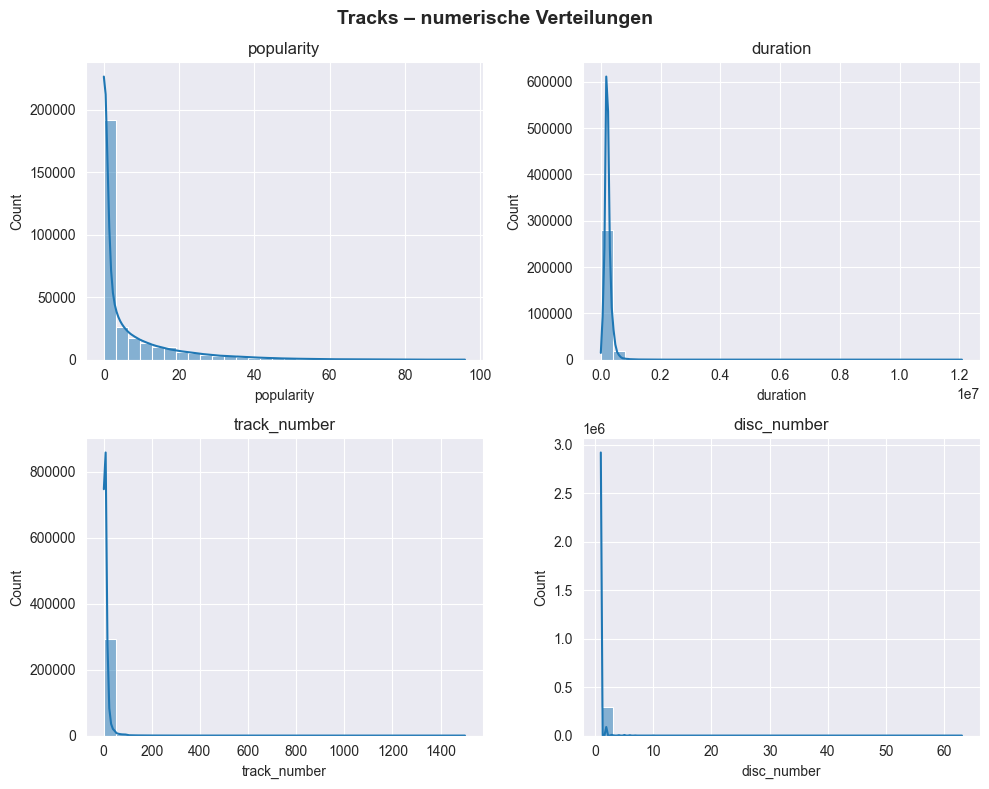

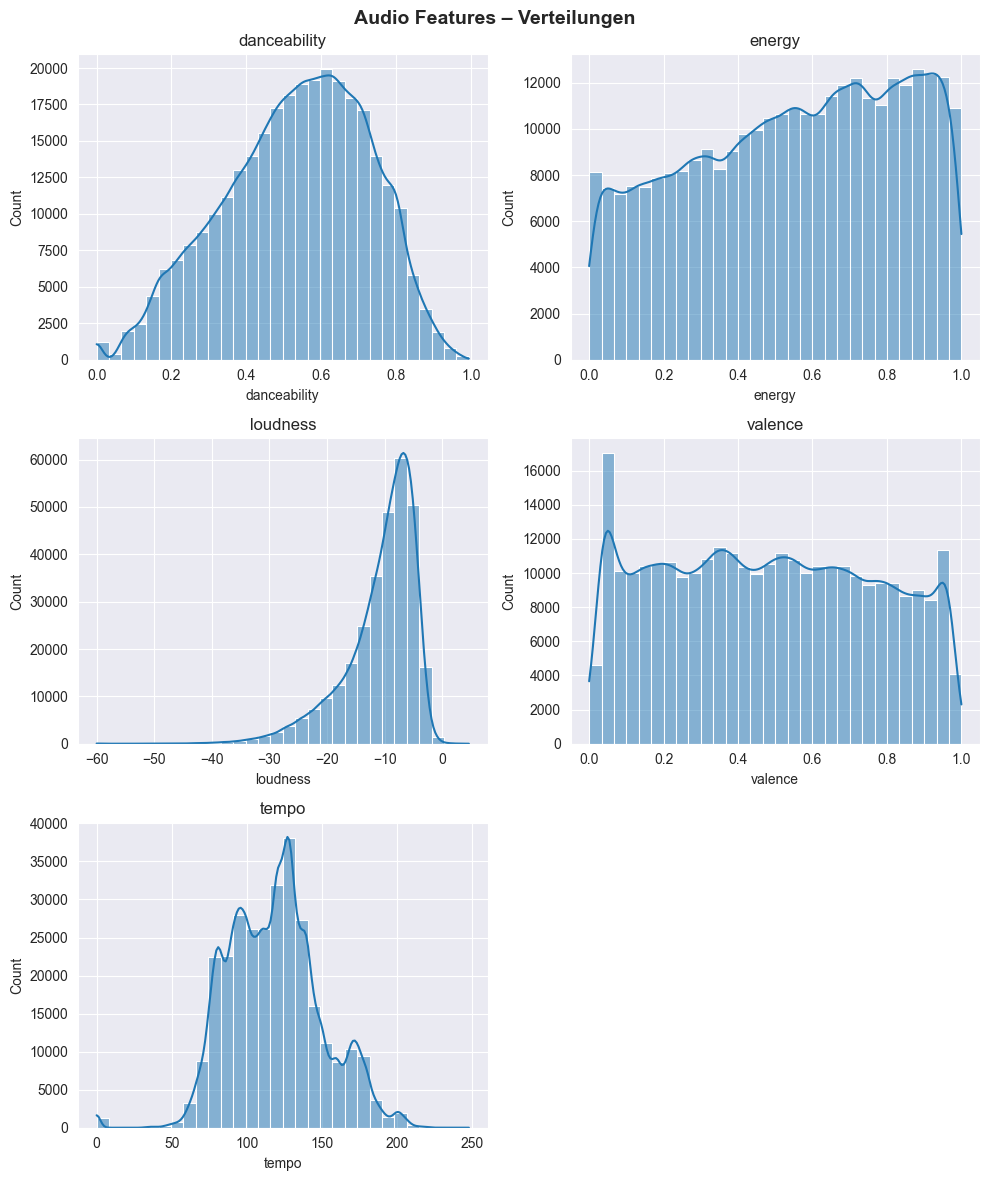

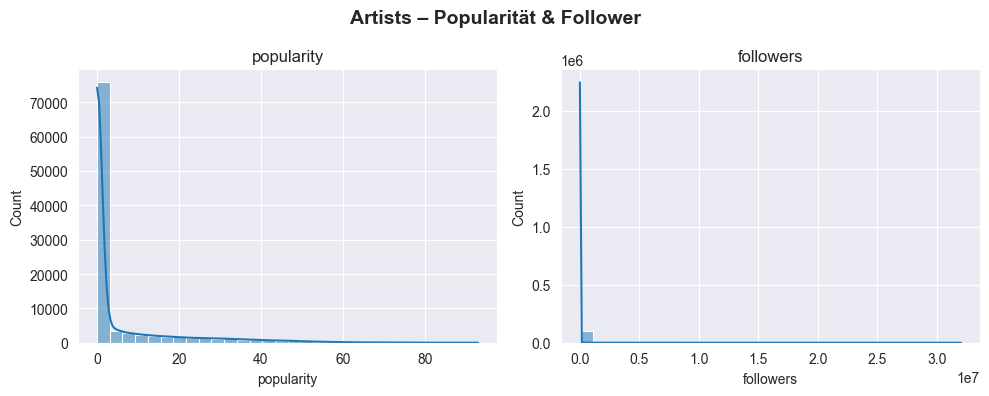

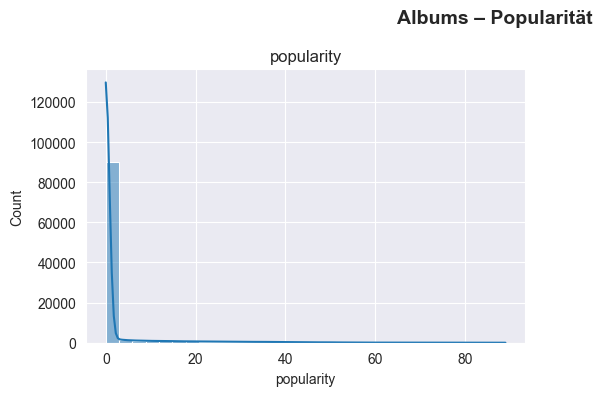

In [8]:
def small_hist_grid(df, cols, title):
    """ Histogramme (2x2 oder 3x2)"""
    n = len(cols)
    ncols = 2
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 4 * nrows))
    axes = axes.flatten()
    for i, col in enumerate(cols):
        sns.histplot(df[col].dropna(), bins=30, ax=axes[i], kde=True)
        axes[i].set_title(col)
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.suptitle(title, fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.show()


# Tracks
track_cols = [c for c in ["popularity", "duration", "track_number", "disc_number"] if c in tracks.columns]
small_hist_grid(tracks, track_cols, "Tracks – numerische Verteilungen")

# Audio Features
audio_cols = [c for c in ["danceability", "energy", "loudness", "valence", "tempo"] if c in audio.columns]
small_hist_grid(audio, audio_cols, "Audio Features – Verteilungen")

# Artists
artist_cols = [c for c in ["popularity", "followers"] if c in artists.columns]
small_hist_grid(artists, artist_cols, "Artists – Popularität & Follower")

# Albums
album_cols = [c for c in ["popularity"] if c in albums.columns]
small_hist_grid(albums, album_cols, "Albums – Popularität")


#### Ausreißer-Erkennung (Z-Score-basierte Quick-Check)

In [11]:
from scipy.stats import zscore


def detect_outliers(df, cols, threshold=3):
    """Compute number of outliers per column using Z-score threshold."""
    outlier_counts = {}
    for col in cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            z = np.abs(zscore(df[col].dropna()))
            outlier_counts[col] = int(np.sum(z > threshold))
    return outlier_counts


# ---- Apply to all main tables ----
tables = {
    "tracks": tracks,
    "audio_features": audio,
    "artists": artists,
    "albums": albums
}

results = {}

for name, df in tables.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if not len(num_cols):
        continue

    outliers = detect_outliers(df, num_cols)
    df_out = (
        pd.DataFrame.from_dict(outliers, orient="index", columns=["n_outliers"])
        .sort_values("n_outliers", ascending=False)
    )
    results[name] = df_out
    print(f"\n {name.upper()} — potenzielle Ausreißer ")
    display(df_out.head(10))  # show top 10 columns with most outliers



 TRACKS — potenzielle Ausreißer 


,n_outliers
explicit,20053
popularity,7925
track_number,2961
disc_number,2366
duration,2318
is_playable,0



 AUDIO_FEATURES — potenzielle Ausreißer 


,n_outliers
liveness,8455
speechiness,6831
time_signature,5679
loudness,4317
duration,2478
tempo,1432
energy,0
danceability,0
acousticness,0
instrumentalness,0



 ARTISTS — potenzielle Ausreißer 


,n_outliers
popularity,3012
followers,219



 ALBUMS — potenzielle Ausreißer 


,n_outliers
popularity,3281
release_date,227
album_group,0


####  Interpretation der Ausreißeranalyse

Die Ausreißer wurden mithilfe des Z-Scores (> 3 σ vom Mittelwert) für alle numerischen Spalten berechnet.
Die Werte zeigen, in welchen Merkmalen einzelne Beobachtungen **ungewöhnlich stark von der Gesamtverteilung abweichen**.

#### 🎵 Tracks
- **explicit (20 053 Ausreißer)** – ungewöhnlich viele Songs, bei denen der Explicit-Wert extrem vom Durchschnitt abweicht.
  → Möglicherweise binär (0/1), daher ist der Z-Score hier weniger aussagekräftig.
- **popularity (7 925)** – einige Songs sind extrem populär (Top-Hits) im Vergleich zur Masse wenig bekannter Tracks.
- **track_number / disc_number** – hohe Werte deuten auf Mehrfach-Alben oder ungewöhnliche Track-Nummerierung hin.
- **duration (2 318)** – Ausreißer durch extrem kurze (Intro/Interlude) oder sehr lange Tracks (> 20 min).
- **is_playable (0)** – keine Ausreißer; gleichmäßig verteilt.

#### 🎧 Audio Features
- **liveness / speechiness / time_signature** – starke Streuung, da diese Features je nach Songtyp sehr variieren.
- **loudness / duration / tempo** – mäßige Ausreißerzahl; teils sehr leise oder extrem schnelle Songs.
- **energy, danceability, acousticness, instrumentalness** – keine Ausreißer → gleichmäßig skalierte Features.

#### 👩‍🎤 Artists
- **popularity (3 012)** – wenige Künstler mit extrem hoher Popularität (Top-Acts).
- **followers (219)** – einzelne Superstars mit Millionen-Followern erzeugen lange Verteilungsschwänze.

#### 💿 Albums
- **popularity (3 281)** – einige sehr erfolgreiche Alben; lange rechte Verteilung.
- **release_date (227)** – fehlerhafte oder ungewöhnlich alte Datumswerte (z. B. fehlende oder falsche Jahresangaben).
- **album_group (0)** – keine Ausreißer; kategorialer Wert.

#### 🧭 Fazit
- Die größten Abweichungen treten bei **Popularität** und **Audio-Charakteristika** wie *liveness* oder *speechiness* auf.
- Diese Merkmale sollten vor Modellierung ggf. **skaliert oder winsorized** werden.
- Binäre Spalten wie `explicit` sollten **nicht per Z-Score** bewertet werden, da sie keine kontinuierliche Skala haben.


#### Vergleichende Verteilungen

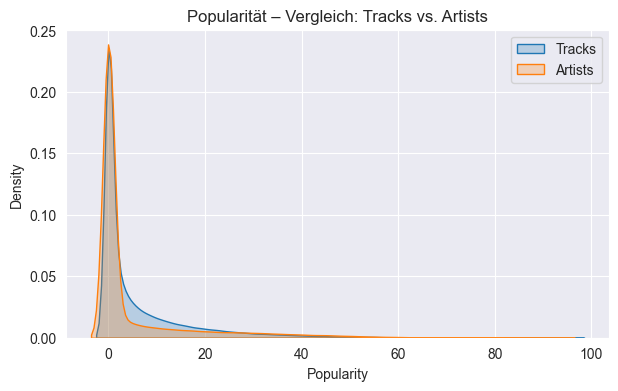

In [13]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.kdeplot(tracks["popularity"], label="Tracks", fill=True)
sns.kdeplot(artists["popularity"], label="Artists", fill=True)
plt.title("Popularität – Vergleich: Tracks vs. Artists")
plt.xlabel("Popularity")
plt.legend()
plt.show()


#### Interpretation

Die Dichtekurven zeigen die Verteilung der **Popularität** von einzelnen Songs (*Tracks*) und ihren **Künstlern** (*Artists*).

**Beobachtungen:**
- Beide Verteilungen sind **linksschief** (starke Häufung im niedrigen Bereich, langer rechter „Schwanz“).
  → Die meisten Songs und Künstler haben geringe Popularitätswerte.
  → Nur wenige erreichen sehr hohe Popularität (Werte über 80–90).
- Die **Künstlerverteilung** ist etwas **breiter und flacher** als die der Tracks:
  → Künstler kumulieren Popularität über mehrere Songs, daher sind extreme Werte seltener.
  → Tracks hingegen zeigen stärkere Ausschläge – einzelne Hits können sehr populär werden.
- Insgesamt dominiert also die „Long Tail“-Struktur: viele unbekannte Titel, wenige Top-Performer.

**Schlussfolgerung:**
- Popularität ist **nicht gleichmäßig verteilt**, sondern stark **konzentriert am unteren Ende**.


#### Zeitbasierte Analyse

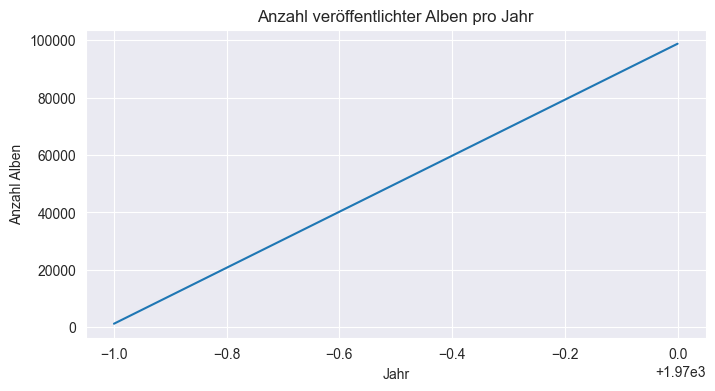

In [14]:
if "release_date" in albums.columns:
    albums["release_date"] = pd.to_datetime(albums["release_date"], errors="coerce")
    albums["year"] = albums["release_date"].dt.year
    year_counts = albums["year"].value_counts().sort_index()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=year_counts.index, y=year_counts.values)
    plt.title("Anzahl veröffentlichter Alben pro Jahr")
    plt.xlabel("Jahr")
    plt.ylabel("Anzahl Alben")
    plt.show()


### 1.5 Feature-Korrelationen

####  Ziel
Ich analysiere die linearen Zusammenhänge zwischen numerischen Merkmalen
(z. B. Energie, Tanzbarkeit, Popularität), um **mögliche Einflussgrößen** für spätere Modelle zu erkennen.

####  Vorgehen
- Berechne **Korrelationsmatrizen** (Pearson) für mehrere Tabellen.
- Visualisiere sie mit **kompakten Heatmaps**.
- Untersuche exemplarisch **wichtige Beziehungen** in Scatterplots.
- Berechne zusätzlich **Korrelations-Rankings** für Popularität.


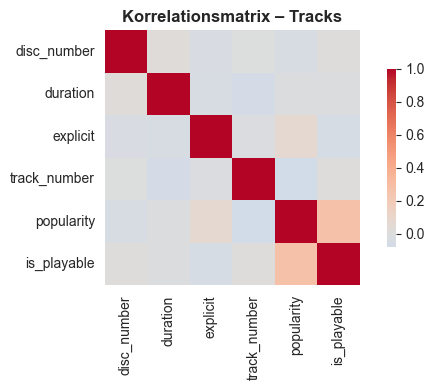

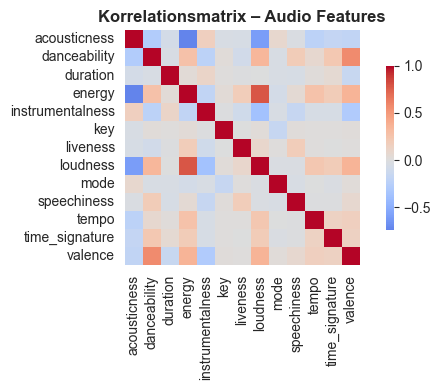

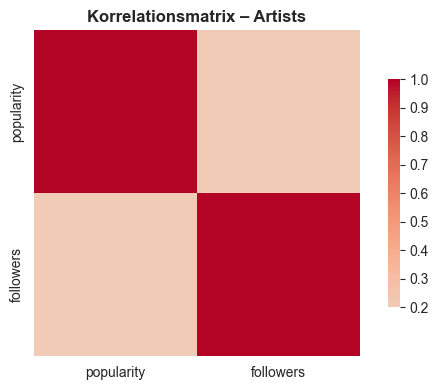

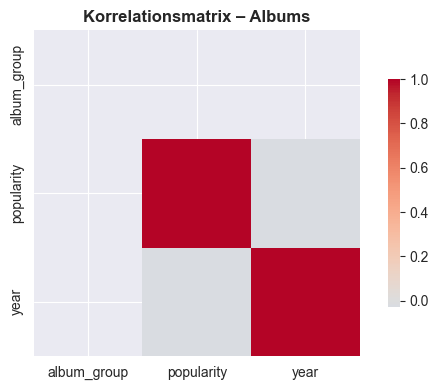

In [15]:
# Annahme: Daten wurden bereits geladen (tracks, audio, artists)
tables = {
    "Tracks": tracks,
    "Audio Features": audio,
    "Artists": artists,
    "Albums": albums
}

# ---------------- Heatmaps pro Tabelle ----------------
for name, df in tables.items():
    num_cols = df.select_dtypes(include=["number"]).columns
    if len(num_cols) < 2:
        continue
    corr = df[num_cols].corr().round(2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        corr, annot=False, cmap="coolwarm", center=0,
        cbar_kws={"shrink": 0.7}, square=True
    )
    plt.title(f"Korrelationsmatrix – {name}", fontsize=12, fontweight="bold")
    plt.tight_layout()
    plt.show()

#### 1.5.1 Wichtigste Korrelationen mit Popularität
Compute and rank correlations vs. popularity (when present).

In [16]:
def corr_with_popularity(df, name):
    if "popularity" not in df.columns:
        return pd.DataFrame()
    num_cols = df.select_dtypes(include=["number"]).columns
    corr = df[num_cols].corr()["popularity"].sort_values(ascending=False)
    corr_df = corr.to_frame(name="corr_with_popularity").reset_index()
    corr_df.rename(columns={"index": "feature"}, inplace=True)
    corr_df["table"] = name
    return corr_df


pop_corrs = []
for n, d in tables.items():
    pop_corrs.append(corr_with_popularity(d, n))

pop_corrs = pd.concat(pop_corrs, ignore_index=True).dropna().sort_values("corr_with_popularity", ascending=False)
display(pop_corrs.head(10))


,feature,corr_with_popularity,table
0,popularity,1.000000,Tracks
8,popularity,1.000000,Albums
6,popularity,1.000000,Artists
1,is_playable,0.267966,Tracks
7,followers,0.201363,Artists
2,explicit,0.065377,Tracks
3,duration,-0.010523,Tracks
9,year,-0.031324,Albums
4,disc_number,-0.041448,Tracks
5,track_number,-0.075585,Tracks


##### Interpretation

Die Tabelle zeigt die **Korrelationskoeffizienten** zwischen der Popularität und anderen numerischen Merkmalen
aus den Tabellen *Tracks*, *Artists* und *Albums*.

**Was bedeutet das?**
- Ein **positiver Korrelationswert** (z. B. `+0.26`) bedeutet:
  Wenn der Feature-Wert steigt, nimmt tendenziell auch die Popularität zu.
- Ein **negativer Wert** (z. B. `–0.07`) bedeutet:
  Wenn der Feature-Wert steigt, sinkt die Popularität leicht.
- Werte nahe **0** zeigen, dass kein linearer Zusammenhang besteht.

**Beobachtungen aus den Ergebnissen:**
- `is_playable` (r ≈ 0.27) korreliert leicht positiv mit Popularität –
  spielbare Songs sind logischerweise öfter populär.
- `followers` (r ≈ 0.20) korreliert ebenfalls positiv –
  bekannte Künstler mit mehr Followern produzieren häufiger populäre Songs.
- `explicit` (r ≈ 0.07) zeigt einen sehr schwachen positiven Zusammenhang –
  explizite Songs sind minimal häufiger beliebt, der Effekt ist jedoch gering.
- `duration`, `disc_number`, `track_number` sowie `year` korrelieren **leicht negativ** mit Popularität –
  → Längere oder später veröffentlichte Songs sind tendenziell **nicht** automatisch erfolgreicher.
- Der Großteil der Korrelationen liegt im Bereich **±0.3**, was auf **keine starken linearen Zusammenhänge** hinweist.

**Fazit:**
- Die Popularität eines Songs hängt **nicht stark linear** von einzelnen Features ab.
- Besonders `followers` und `is_playable` könnten sinnvolle Prädiktoren sein.


### 1.5.2 Visualisierung wichtiger Beziehungen

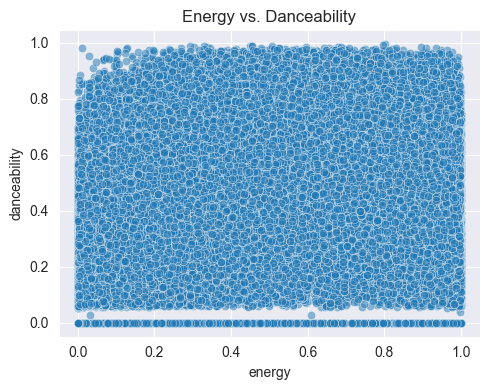

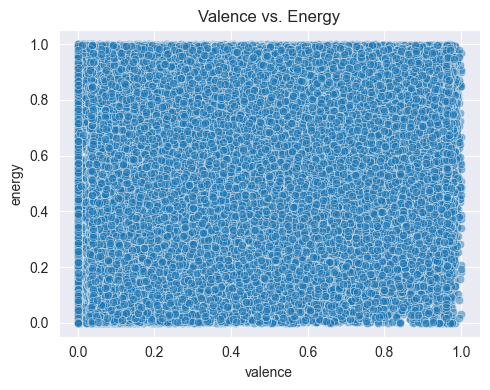

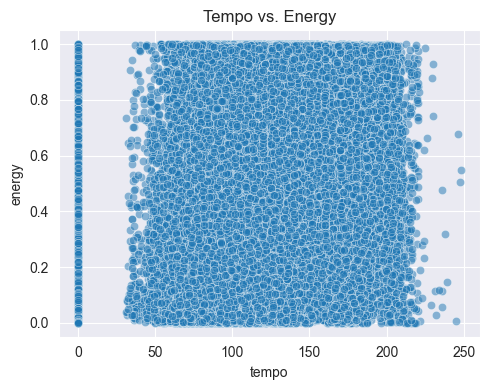

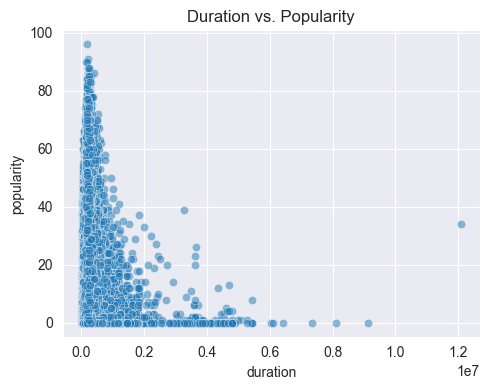

In [17]:
def small_scatter(df, x, y, title):
    plt.figure(figsize=(5, 4))
    sns.scatterplot(data=df, x=x, y=y, alpha=0.5)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Beispiele aus Audio-Features + Tracks
if all(c in audio.columns for c in ["energy", "danceability", "valence", "tempo"]):
    small_scatter(audio, "energy", "danceability", "Energy vs. Danceability")
    small_scatter(audio, "valence", "energy", "Valence vs. Energy")
    small_scatter(audio, "tempo", "energy", "Tempo vs. Energy")

if all(c in tracks.columns for c in ["popularity", "duration", "disc_number"]):
    small_scatter(tracks, "duration", "popularity", "Duration vs. Popularity")


Die Streudiagramme zeigen, wie stark einzelne musikalische Eigenschaften miteinander oder mit der Popularität zusammenhängen.

#### 🎧 Energy vs. Danceability
- Die Punkte sind über den gesamten Bereich verteilt – es gibt **keine klare lineare Beziehung**.
- Tendenziell liegen viele Songs im **mittleren Bereich beider Achsen** (moderate Energie und Tanzbarkeit).
- Das deutet darauf hin, dass **tanzbare Songs nicht automatisch energiegeladener** sind –
  ruhige, aber rhythmische Songs kommen ebenso vor wie laute, aber weniger tanzbare.

#### 🎵 Valence vs. Energy
- Auch hier zeigt sich **keine starke lineare Korrelation**.
- Die meisten Songs befinden sich **im Mittelfeld** – also weder extrem fröhlich (*Valence*) noch extrem energiegeladen.
- Nur wenige Punkte liegen in den oberen Quadranten → sehr fröhliche und gleichzeitig energievolle Songs sind eher selten.

#### 🕒 Tempo vs. Energy
- Die Punkte konzentrieren sich **im mittleren Bereich** des Tempos.
- Schnellere Songs (höheres Tempo) sind **nicht zwingend energiegeladener**,
  was auf stilistische Vielfalt hindeutet – z. B. schnelle, aber leise Songs oder langsame, kraftvolle Stücke.

#### ⏱ Duration vs. Popularity
- Die meisten Punkte liegen **links im Diagramm** → viele Songs haben **kurze Dauer**.
- Im oberen Bereich (hohe Popularität) sind nur wenige Punkte → **lange Songs sind seltener populär**.
- Es gibt also **keinen positiven Zusammenhang** zwischen Songlänge und Erfolg;
  kurze, kompakte Songs dominieren die populären Titel.

#### 🧭 Fazit
- Zwischen den Audio-Features bestehen **überwiegend nichtlineare oder schwache Zusammenhänge**.
- Besonders **Energy**, **Danceability** und **Valence** liegen im mittleren Bereich vieler Songs –
  typische Eigenschaften moderner Pop-Produktionen.
- Für Popularität sind **andere Faktoren** (z. B. Artist-Reputation, Marketing, Veröffentlichungszeitpunkt)
  vermutlich wichtiger als einzelne Audio-Merkmale.


### 1.5.3 Scatter-Matrix

<Figure size 800x600 with 0 Axes>

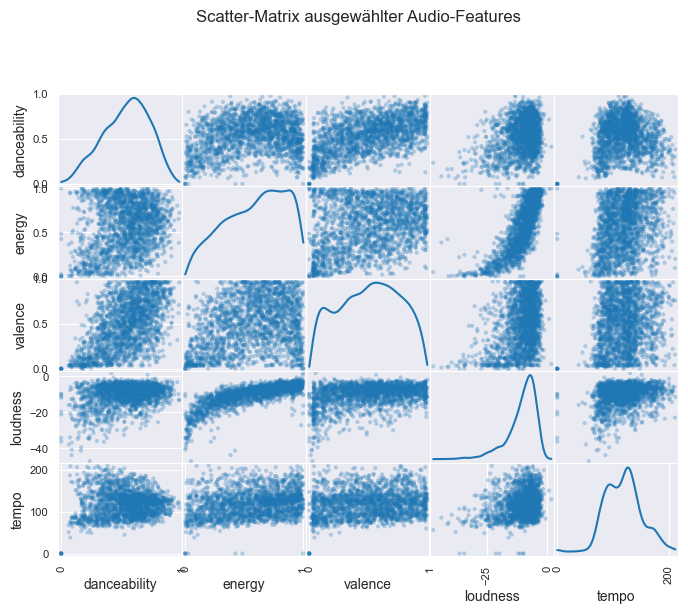

In [18]:
from pandas.plotting import scatter_matrix

selected_cols = [c for c in ["danceability", "energy", "valence", "loudness", "tempo"] if c in audio.columns]
if len(selected_cols) >= 3:
    plt.figure(figsize=(8, 6))
    scatter_matrix(audio[selected_cols].sample(2000, random_state=42), figsize=(8, 6), alpha=0.3, diagonal="kde")
    plt.suptitle("Scatter-Matrix ausgewählter Audio-Features", y=1.02, fontsize=12)
    plt.show()


**Was sehe ich hier?**
- **Diagonale (KDE-Kurven):** Verteilung jedes einzelnen Features
  → z. B. ob *danceability* oder *energy* eher mittig geballt, schief verteilt oder mit Ausreißern ist.
- **Off-Diagonale (Punktwolken):** Paarweise Beziehungen zwischen zwei Features
  → Form/Trend der Wolke ≈ Stärke/Art des Zusammenhangs (linear, nichtlinear, gar keiner).

**Wie lese ich das für diese Features?**
- **energy ↔ loudness:** Erwartet **deutlich positiver Trend** (lautere Songs wirken energiegeladener).
- **danceability ↔ valence:** Häufig **moderater positiver Trend** (tanzbare Songs sind tendenziell „fröhlicher“).
- **tempo ↔ (energy/danceability):** Meist **schwacher** oder diffuser Zusammenhang (viel Mitte, wenig klare Linie).
- **valence/energy/danceability (diagonal):** Dichten oft **mittig** → typische Pop-Produktionen mit moderaten Werten, wenige Extreme.

**Wozu ist das nützlich?**
- Erkennt **korrelierte Feature-Paare** → mögliche **Multikollinearität** (später für Modellwahl/Feature-Selektion wichtig).
- Zeigt **Nichtlinearitäten/Cluster** → Hinweis, dass **nichtlineare Modelle** (RF/XGBoost) sinnvoll sein könnten.
- Macht **Ausreißer** sichtbar → Kandidaten für Winsorizing/Robust-Scaler.

**Wenn die Punkte „überall“ liegen:**
- Dann gibt es **keinen klaren linearen Zusammenhang** (Pearson klein).
- Prüfe ggf. **Spearman-Rangkorrelation** (monotone, nichtlineare Trends).
- Nutze **Hexbin/Dichteplots**, wenn Überlagerung die Struktur verdeckt.